# Uncertainty 

This is a tutorial for the uncertainty module.

## Uncertainty and sensitivity analysis?

Before doing an uncertainty analysis in CLIMADA, it is imperative that you get first comfortable with the different notions of uncertainty in the modelling world (see e.g. [Douglas-Smith(2020)](https://doi.org/10.1007/978-1-4899-7547-8_5) for a review). In particular, note that the uncertaintity values will only be as good as the input from the user. In addition, not all uncertainties can be numerically quantified, and even worse, some unkonwns are unknown. This means that sometimes, quantifying uncertainty can lead to false confidence in the output!. For a more philosophical discussion about the types of uncertainties in climate research see [Knüsel2020](https://www.research-collection.ethz.ch/handle/20.500.11850/399735).

In this module, it is possible to perform global uncertainty analysis, as well as a sensitivity analysis. The word global is meant as opposition to the 'one-factor-at-a-time' (OAT) strategy. The OAT strategy, which consists in analyzing the effect of varying one model input factor at a time while keeping all other fixed, is popular among modellers, but has major shortcomings [Saltelli (2010)](https://www.sciencedirect.com/science/article/abs/pii/S1364815210001180), [Saltelli(2019)](http://www.sciencedirect.com/science/article/pii/S1364815218302822) and should not be used.

A rough schemata of how to perform uncertainty and sensitivity analysis (taken from [Saltelli(2019)](http://www.sciencedirect.com/science/article/pii/S1364815218302822))

<img src="./img/UncertaintySensitivity.jpg" alt="Uncertainty and Sensitivity analysis" width="600">

1. [Douglas-Smith, D., Iwanaga, T., Croke, B. F. W. & Jakeman, A. J. Certain trends in uncertainty and sensitivity analysis: An overview of software tools and techniques. Environmental Modelling & Software 124, 104588 (2020)](https://doi.org/10.1007/978-1-4899-7547-8_5)
2. [Knüsel, B. Epistemological Issues in Data-Driven Modeling in Climate Research. (ETH Zurich, 2020)](https://www.research-collection.ethz.ch/handle/20.500.11850/399735)
3. [Saltelli, A. et al. Why so many published sensitivity analyses are false: A systematic review of sensitivity analysis practices. Environmental Modelling & Software 114, 29–39 (2019)](http://www.sciencedirect.com/science/article/pii/S1364815218302822)
4. [Saltelli, A. & Annoni, P. How to avoid a perfunctory sensitivity analysis. Environmental Modelling & Software 25, 1508–1517 (2010)](https://www.sciencedirect.com/science/article/abs/pii/S1364815210001180)

##  Uncertainty Module Structure

The uncertainty module contains 2 main classes
- `UncVar`: defines uncertainty variables
- `Uncertainty`: base class to compute uncertainties and sensitivities for CLIMADA outputs.

In addition, there are the child classes of `Uncertainty` defined in their submodules:

- `UncImpact`: specific class to compute uncertainties for outputs of `climada.engine.impact.calc`
- `UncCostBenefit`: specific class to compute uncertainties for outputs of `climada.engine.cost_benefit.calc`

## UncVar 

The UncVar class is used to define uncertainty variables. 

| Attribute | Type | Description |
| --- | --- | --- |
| uncvar_func | funnction | Variable defined as a function of the uncertainty parameters |
| distr_dict | dict | Dictionary of the probability density distributions of the uncertainty parameters |

An **uncertainty parameter** is an input value that has a certain probability density distribution in your model, such as the total exposure asset value, the slope the vulnerability function, the exponent of the litpop exposure,  the value of the discount rate, the cost of an adaptation measure, ... 

The probability densitity distributions (values of `distr_dict`) of the uncertainty parameters (keyword arguments of the `uncvar_func` and keys of the `distr_dict`) can be any of the ones defined in [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html).

### Example - continuous uncertainty parameter

Suppose we assume that the GDP value used to scale the exposure has a relative error of +-10%. 

In [1]:
#Define the base exposure
from climada.util.constants import EXP_DEMO_H5
from climada.entity import Exposures
exp_base = Exposures()
exp_base.read_hdf5(EXP_DEMO_H5)

2021-06-09 12:16:32,165 - climada.entity.exposures.base - INFO - Reading /Users/ckropf/climada/demo/data/exp_demo_today.h5


In [2]:
# Define the function that returns an exposure with scaled total assed value
# Here x_exp is the uncertainty parameter and exp_func the uncvar_func.
def exp_func(x_exp, exp_base=exp_base):
    exp = exp_base.copy()
    exp.gdf.value *= x_exp
    return exp

In [3]:
# Define the Uncertainty Variable with +-10% total asset value
# The probability density distribution of the uncertainty parameter x_exp is sp.stats.uniform(0.9, 1.1)
from climada.engine.uncertainty import UncVar
import scipy as sp

exp_distr = {"x_exp": sp.stats.uniform(0.9, 1.1),
              }
exp_unc = UncVar(exp_func, exp_distr)

In [4]:
# Uncertainty parameters
exp_unc.labels

['x_exp']

In [5]:
# Evaluate for a given value of the uncertainty parameters
exp095 = exp_unc.uncvar_func(x_exp = 0.95)
print(f"Base value is {exp_base.gdf['value'].sum()}, and the value for x_exp=0.95 is {exp095.gdf['value'].sum()}")

Base value is 657053294559.9105, and the value for x_exp=0.95 is 624200629831.9148


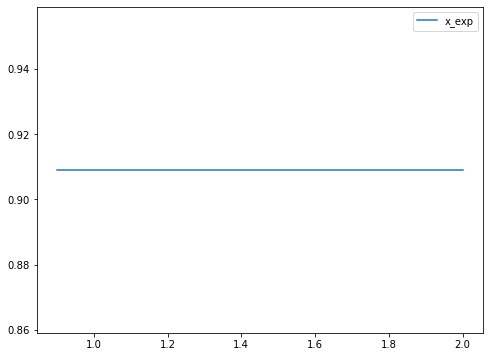

In [6]:
# Defined distribution
exp_unc.plot(figsize=(8, 6));

### Example - categorical uncertainty parameter 

Suppose we want to test different exponents (m=0,1,2 ; n=0,1,2) for the LitPop exposure for the country Switzerland.

In [7]:
from climada.entity import LitPop

m_min, m_max = (0, 2)
n_min, n_max = (0, 2)

# Define the function
# Note that this here works, but might be slow because the method LitPop is called everytime the the function
# is evaluated, and LitPop is relatively slow. 
def litpop_cat(m, n):
    exp = Litpop()
    exp.set_country('CHE', exponent=[m, n])
    return exp

In [ ]:
# A faster method would be to first create a dictionnary with all the exposures. This however
# requires more memory and precomputation time (here ~3-4mins)
exp = LitPop()
litpop_dict = {}
for m in range(m_min, m_max + 1):
    for n in range(n_min, n_max + 1):
        exp_mn = exp.copy()
        exp_mn.set_country('CHE', exponent=[m, n])
        litpop_dict[(m, n)] = exp_mn
        
def litpop_cat(m, n, litpop_dict=litpop_dict):
    return litpop_dict[(m, n)]

In [ ]:
#Define the distribution dictionnary
import scipy as sp
from climada.engine.uncertainty import UncVar

distr_dict = {
    'm': sp.stats.randint(low=m_min, high=m_max),
    'n': sp.stats.randint(low=n_min, high=n_max)
    }

unc_var_cat = UncVar(litpop_cat, distr_dict) # One can use either of the above definitions of litpop_cat

In [ ]:
# Uncertainty parameters
unc_var_cat.labels

##  UncImpact

### Set the UncVars 

import scipy as sp
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from pathos.pools import ProcessPool as Pool

from climada.engine.uncertainty import UncVar, Uncertainty, UncImpact, UncCostBenefit
from climada.entity import ImpactFunc, ImpactFuncSet, Exposures
from climada.entity.entity_def import Entity
from climada.hazard import Hazard
from climada.util.value_representation import value_to_monetary_unit as vtm
from climada.util.plot import multibar_plot
from climada.util.constants import EXP_DEMO_H5, HAZ_DEMO_H5, ENT_DEMO_TODAY, ENT_DEMO_FUTURE

In this example, we model the impact function for tropical cyclones on the parametric function suggested in Emanuel (2015) with 4 parameters. The exposures total value varies between 80% and 120%. For that hazard, we assume to have no good error estimate and thus do not define an UncVar for the hazard.

In [3]:
#Define the uncvar_funcs
import numpy as np

from climada.entity import ImpactFunc, ImpactFuncSet, Exposures
from climada.util.constants import EXP_DEMO_H5, HAZ_DEMO_H5
from climada.hazard import Hazard

def impf_func(G=1, v_half=84.7, vmin=25.7, k=3, _id=1):    
    imp_fun = ImpactFunc()
    imp_fun.haz_type = 'TC'
    imp_fun.id = _id
    imp_fun.intensity_unit = 'm/s'
    imp_fun.intensity = np.linspace(0, 150, num=100)
    imp_fun.mdd = np.repeat(1, len(imp_fun.intensity))
    imp_fun.paa = np.array([sigmoid_func(v, G, v_half, vmin, k) for v in imp_fun.intensity])
    imp_fun.check()
    impf_set = ImpactFuncSet()
    impf_set.append(imp_fun)
    return impf_set

def xhi(v, v_half, vmin):
    return max([(v - vmin), 0]) / (v_half - vmin)
  
def sigmoid_func(v, G, v_half, vmin, k):
    return G * xhi(v, v_half, vmin)**k / (1 + xhi(v, v_half, vmin)**k)

haz = Hazard()
haz.read_hdf5(HAZ_DEMO_H5)

exp_base = Exposures()
exp_base.read_hdf5(EXP_DEMO_H5)
#It is a good idea to assign the centroids to the base exposures in order to avoid repeating this
# potentially costly operation for each sample.
exp_base.assign_centroids(haz) 

def exp_func(x_exp, exp_base=exp_base):
    exp = exp_base.copy()
    exp.gdf.value *= x_exp
    exp.check()
    return exp


2021-06-10 16:25:37,506 - climada.hazard.base - INFO - Reading /Users/ckropf/climada/demo/data/tc_fl_1990_2004.h5
2021-06-10 16:25:37,542 - climada.entity.exposures.base - INFO - Reading /Users/ckropf/climada/demo/data/exp_demo_today.h5
2021-06-10 16:25:37,625 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.


/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


2021-06-10 16:25:40,158 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


<AxesSubplot:title={'center':'TC 1: '}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>

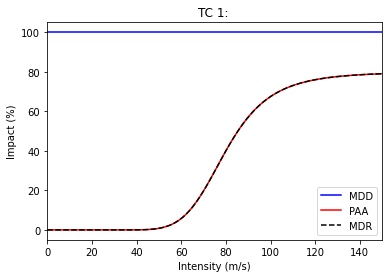

In [4]:
# Visualization of the parametrized impact function
impf_func(G=0.8, v_half=80, vmin=30,k=5).plot()

In [5]:
#Define the UncVars

import scipy as sp
from climada.engine.uncertainty import UncVar

exp_distr = {"x_exp": sp.stats.beta(0.8, 1.2),
              }
exp_unc = UncVar(exp_func, exp_distr)

impf_distr = {
    "G": sp.stats.truncnorm(0.8,1.2),
    "v_half": sp.stats.uniform(35, 100),
    "vmin": sp.stats.uniform(0, 15),
    "k": sp.stats.uniform(1, 5)
    }
impf_unc = UncVar(impf_func, impf_distr)

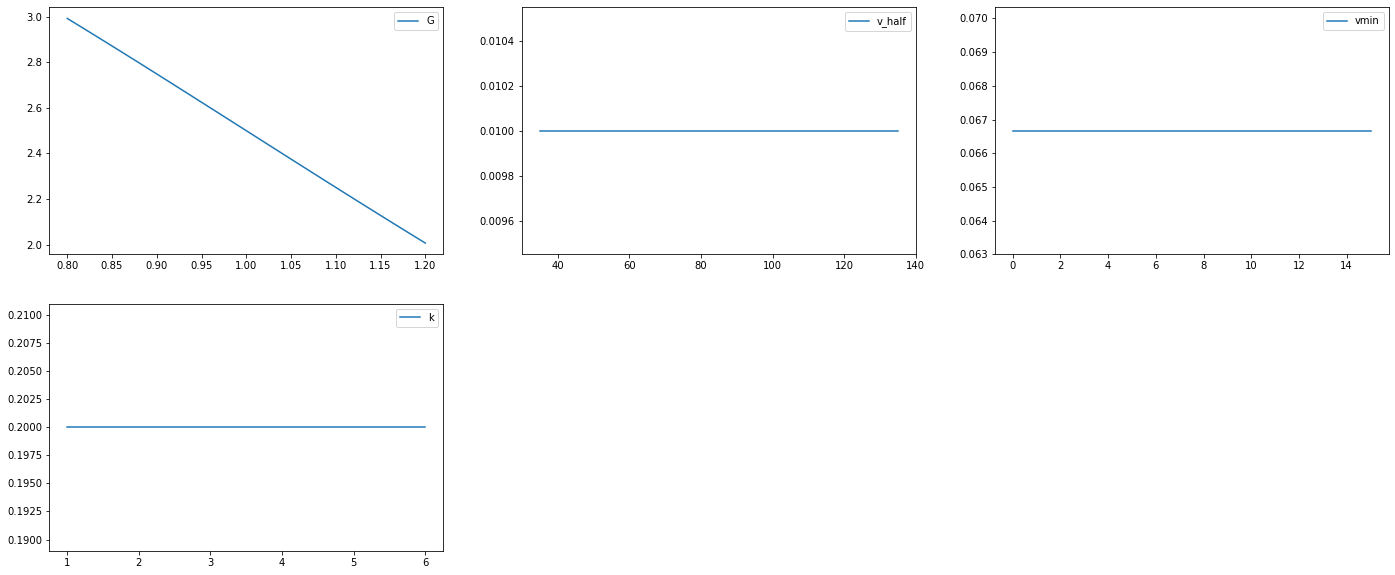

In [4]:
impf_unc.plot();

### Compute uncertainty and sensitivity using default methods 

First, we define the UncImpact object with our uncertainty variables. 

In [6]:
from climada.engine.uncertainty import UncImpact

unc = UncImpact(exp_unc, impf_unc, haz)

Next, we generate samples for the uncertainty parameters using the default methods. Note that depending on the chosen Salib method, the effective number of samples differs from the input variable N. For the default 'saltelli', with `calc_second_order=True`, the effective number is N(2D+2), with D the number of uncertainty parameters. See [SAlib](https://salib.readthedocs.io/en/latest/api.html) for more information.

In [7]:
unc.make_sample(N=100)

2021-06-10 16:26:14,936 - climada.engine.uncertainty.base - INFO - Effective number of made samples: 1200


,x_exp,G,v_half,vmin,k
0,0.125521,0.832731,86.855469,10.151367,2.401367
1,0.833040,0.832731,86.855469,10.151367,2.401367
2,0.125521,0.815430,86.855469,10.151367,2.401367
3,0.125521,0.832731,124.941406,10.151367,2.401367
4,0.125521,0.832731,86.855469,7.514648,2.401367
...,...,...,...,...,...
1195,0.600502,1.015208,41.396484,11.037598,4.239746
1196,0.600502,0.853179,91.494141,11.037598,4.239746
1197,0.600502,0.853179,41.396484,1.560059,4.239746
1198,0.600502,0.853179,41.396484,11.037598,5.855957


The resulting samples can be visualized in plots.

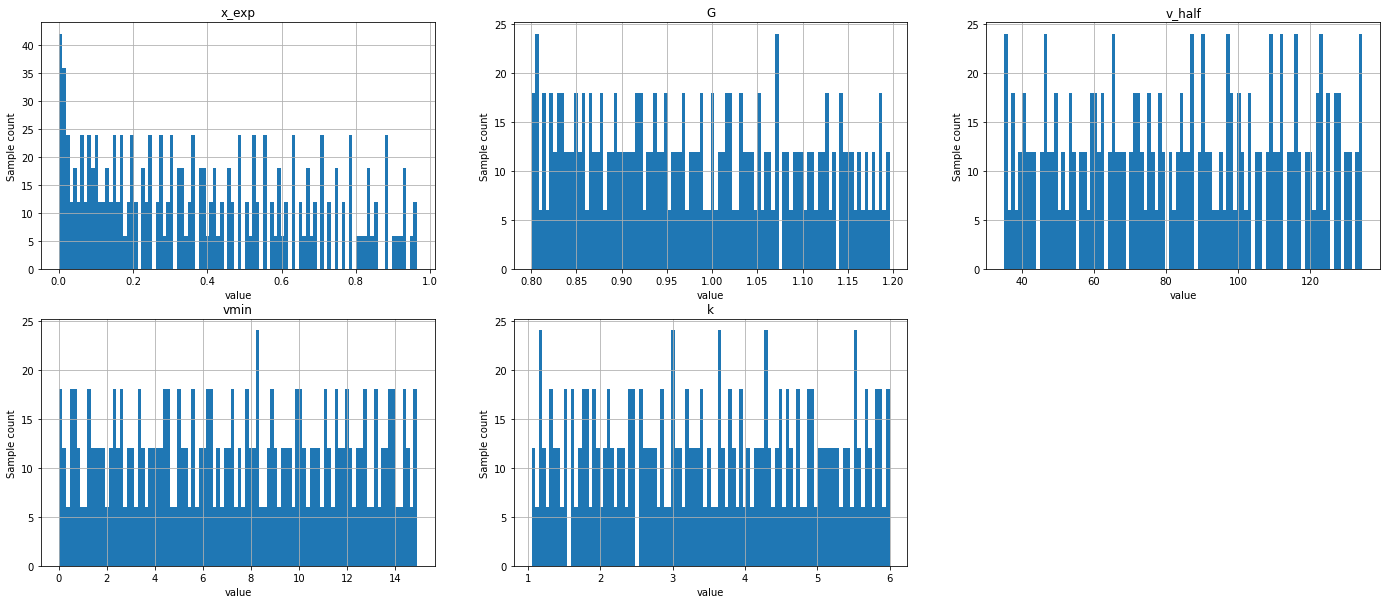

In [8]:
unc.plot_sample();

Now we can compute the value of the impact metrics for all the samples. In this example, we additionaly chose to restrict the return periods 50, 100, and 250 years. By default, `eai_exp` and `at_event` are not stored.

In [9]:
unc.calc_distribution(rp = [50, 100, 250])

2021-06-10 16:26:21,854 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-06-10 16:26:21,856 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-06-10 16:26:21,858 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-06-10 16:26:21,864 - climada.engine.uncertainty.unc_impact - INFO - 

Estimated computation time: 20.16 s



The distributions of metrics ouputs are stored as dictionaries of pandas dataframe. The metrics are directly taken from the output of `climada.impact.calc`. 

In [10]:
unc.metrics

{'aai_agg':            aai_agg
 0     1.452259e+08
 1     9.638108e+08
 2     1.422086e+08
 3     5.798529e+07
 4     1.699837e+08
 ...            ...
 1195  3.466737e+09
 1196  8.223227e+07
 1197  3.519707e+09
 1198  2.475507e+09
 1199  2.913440e+09
 
 [1200 rows x 1 columns],
 'freq_curve':               rp50         rp100         rp250
 0     4.190439e+09  5.459388e+09  6.716189e+09
 1     2.781041e+10  3.623196e+10  4.457288e+10
 2     4.103377e+09  5.345963e+09  6.576651e+09
 3     1.668605e+09  2.195785e+09  2.728832e+09
 4     4.852968e+09  6.169638e+09  7.454678e+09
 ...            ...           ...           ...
 1195  1.027197e+11  1.440714e+11  1.832228e+11
 1196  2.242984e+09  3.585708e+09  5.083031e+09
 1197  1.027906e+11  1.314927e+11  1.574598e+11
 1198  7.067343e+10  1.096797e+11  1.503698e+11
 1199  8.632543e+10  1.210773e+11  1.539801e+11
 
 [1200 rows x 3 columns],
 'eai_exp': Empty DataFrame
 Columns: []
 Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,

In [11]:
unc.calc_sensitivity()

{'aai_agg': {'aai_agg': {'S1': array([0.35319533, 0.02894084, 0.29014581, 0.00245273, 0.07358847]),
   'S1_conf': array([0.1728537 , 0.03609122, 0.18363595, 0.02232441, 0.13158764]),
   'ST': array([0.45797138, 0.02597843, 0.58556506, 0.01358738, 0.2763128 ]),
   'ST_conf': array([0.20627501, 0.01731126, 0.31435897, 0.00749181, 0.14977491]),
   'S2': array([[        nan, -0.24100036, -0.0349894 , -0.24132635, -0.169576  ],
          [        nan,         nan, -0.05162803, -0.04726681, -0.04375917],
          [        nan,         nan,         nan, -0.02073784,  0.00665134],
          [        nan,         nan,         nan,         nan, -0.00056325],
          [        nan,         nan,         nan,         nan,         nan]]),
   'S2_conf': array([[       nan, 0.25671831, 0.42807025, 0.25448881, 0.26287945],
          [       nan,        nan, 0.07386641, 0.06784545, 0.04702821],
          [       nan,        nan,        nan, 0.27235389, 0.30221214],
          [       nan,        nan,  

In [103]:
def plot_sensitivity2d(self, salib_si='S2', metric_list=None, figsize=None):

    if not self.metrics:
        raise ValueError("No sensitivity present for this metrics. "
                "Please run a sensitivity analysis first.")

    if metric_list is None:
        metric_list = ['aai_agg', 'freq_curve', 'tot_climate_risk',
                       'tot_value', 'benefit', 'cost_ben_ratio',
                       'imp_meas_present', 'imp_meas_future', 'tot_value']

    #all the lowest level metrics (e.g. rp10) directly or as 
    #submetrics of the metrics in metrics_list
    submetric_list = []
    for metric_name, metric_dict in self.sensitivity.items():
        if metric_name in metric_list:
            submetric_list.append(list(metric_dict.keys())[0])
        submetric_list += [submetric_name
         for submetric_name, submetric_dict in metric_dict.items()
         if submetric_name in metric_list
         ]
    #remove duplicate
    submetric_list = list(set(submetric_list))
        
    nplots = len(submetric_list)
    nrows, ncols = int(np.ceil(nplots / 3)), min(nplots, 3)
    if not figsize:
        figsize = (ncols * FIG_W, nrows * FIG_H)
    _fig, axes = plt.subplots(nrows = nrows,
                             ncols = ncols,
                             figsize = figsize)
    if nplots > 1:
        flat_axes = axes.flatten()
    else:
        flat_axes = np.array([axes])

    #dictionnary of sensitivity indices of all lowest level metrics
    si_dict = {}
    for metric_dict in self.sensitivity.values():
        si_dict.update(metric_dict)
    
    for ax, submetric in zip_longest(flat_axes, submetric_list, fillvalue=None):
        if submetric is None:
            ax.remove()
            continue
        #Make matrix symmetric
        s2_matrix = np.triu(np.asmatrix(si_dict[submetric]['S2']))
        s2_matrix = s2_matrix + s2_matrix.T - np.diag(np.diag(s2_matrix))
        ax.matshow(s2_matrix, cmap='OrRd')
        for i in range(len(s2_matrix)):
            for j in range(len(s2_matrix)):
                text = ax.text(j, i, round(s2_matrix[i, j], 2),
                               ha="center", va="center",
                               color="k", fontsize='medium')
        ax.set_title(salib_si + ' - ' + submetric, fontsize=18)
        labels = self.param_labels
        ax.set_xticklabels(labels, fontsize=16)
        ax.set_yticklabels(labels, fontsize=16)
    plt.tight_layout()

    return axes

<ipython-input-103-4931e986f8f2>:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize=16)
<ipython-input-103-4931e986f8f2>:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels, fontsize=16)


array([<AxesSubplot:title={'center':'S2 - rp50'}>,
       <AxesSubplot:title={'center':'S2 - tot_value'}>,
       <AxesSubplot:title={'center':'S2 - aai_agg'}>], dtype=object)

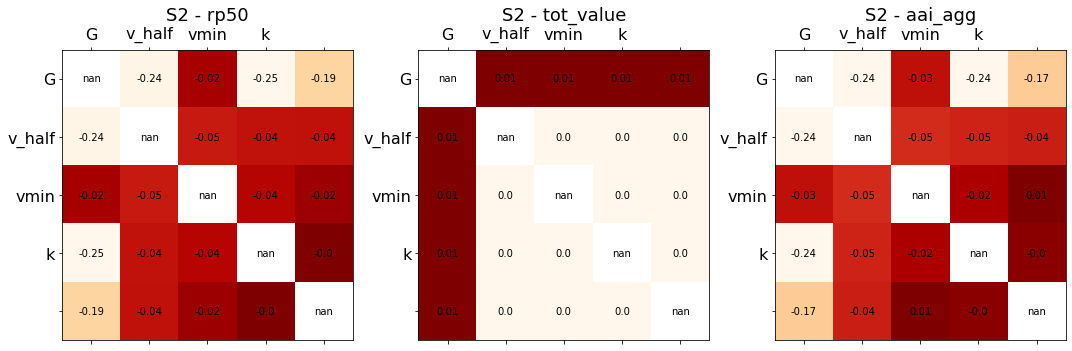

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import zip_longest
from climada.util.value_representation import value_to_monetary_unit as u_vtm
METRICS_2D = ['eai_exp', 'at_event']
FIG_W, FIG_H = 5, 5
plot_sensitivity2d(unc)

In [77]:
def plot_distribution(self, metric_list=None, figsize=None, log=False):
    """
    Plot the distribution of values.

    Parameters
    ----------
    metric_list: list, optional
        List of metrics to plot the distribution.
        The default is None.
    figsize: tuple(int or float, int or float), optional
        The figsize argument of matplotlib.pyplot.subplots()
        The default is derived from the total number of plots (nplots) as:
            nrows, ncols = int(np.ceil(nplots / 3)), min(nplots, 3)
            figsize = (ncols * FIG_W, nrows * FIG_H)
    log: boolean
        Use log10 scale for x axis. Default is False

    Raises
    ------
    ValueError
        If no metric distribution was computed the plot cannot be made.

    Returns
    -------
    axes: matplotlib.pyplot.axes
        The axes handle of the plot.

    """
    fontsize = 18 #default label fontsize

    if not self.metrics:
        raise ValueError("No uncertainty data present for these metrics. "+
                "Please run an uncertainty analysis first.")

    if metric_list is None:
        metric_list = list(self.metrics.keys())

    df_values = pd.DataFrame()
    for metric in metric_list:
        if metric not in METRICS_2D:
            df_values = df_values.append(self.metrics[metric])

    if log:
        df_values_plt = df_values.apply(np.log10).copy()
        df_values_plt = df_values_plt.replace([np.inf, -np.inf], np.nan)
    else:
        df_values_plt = df_values.copy()

    cols = df_values_plt.columns
    nplots = len(cols)
    nrows, ncols = int(np.ceil(nplots / 2)), min(nplots, 2)
    if not figsize:
        figsize = (ncols * FIG_W, nrows * FIG_H)
    _fig, axes = plt.subplots(nrows = nrows,
                             ncols = ncols,
                             figsize = figsize)
    if nplots > 1:
        flat_axes = axes.flatten()
    else:
        flat_axes = np.array([axes])

    for ax, col in zip_longest(flat_axes, cols, fillvalue=None):
        if col is None:
            ax.remove()
            continue
        data = df_values_plt[col]
        if data.empty:
            ax.remove()
            continue
        data.hist(ax=ax, bins=30, density=True, histtype='bar',
                  color='lightsteelblue', edgecolor='black')
        data.plot.kde(ax=ax, color='darkblue', linewidth=4, label='')
        avg = df_values[col].mean()
        std = df_values[col].std()
        ax.axvline(np.log10(avg), color='darkorange', linestyle='dashed', linewidth=2,
                label="avg=%.2f%s" %u_vtm(avg))
        ax.plot([np.log10(avg) - np.log10(std) / 2,
                 np.log10(avg) + np.log10(std) / 2],
                [0.3, 0.3], color='black',
                label="std=%.2f%s" %u_vtm(std))
        ax.set_title(col)
        if log:
            ax.set_xlabel('value [log10]')
        else:
            ax.set_xlabel('value')
        ax.set_ylabel('density of events')
        ax.legend(fontsize=fontsize-2)
        
        ax.tick_params(labelsize=fontsize)
        for item in [ax.title, ax.xaxis.label, ax.yaxis.label]:
            item.set_fontsize(fontsize)
    plt.tight_layout()

    return axes

/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Users/ckropf/opt/anaconda3/envs/climada_210/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Users/ckropf/opt/anaconda3/

array([[<AxesSubplot:title={'center':'aai_agg'}, xlabel='value [log10]', ylabel='density of events'>,
        <AxesSubplot:title={'center':'rp50'}, xlabel='value [log10]', ylabel='density of events'>],
       [<AxesSubplot:title={'center':'rp100'}, xlabel='value [log10]', ylabel='density of events'>,
        <AxesSubplot:title={'center':'rp250'}, xlabel='value [log10]', ylabel='density of events'>],
       [<AxesSubplot:title={'center':'tot_value'}, xlabel='value [log10]', ylabel='density of events'>,
        <AxesSubplot:>]], dtype=object)

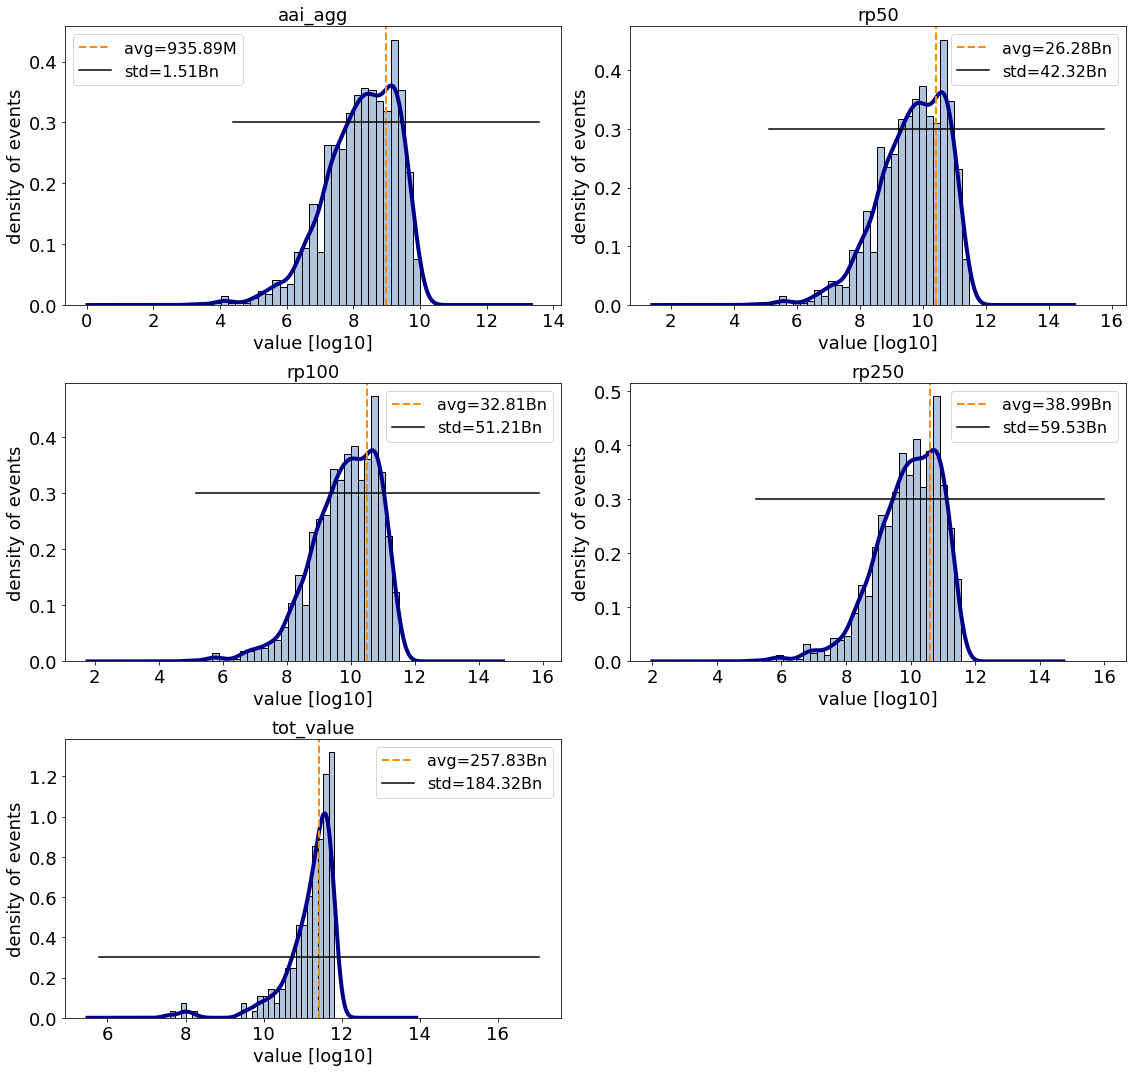

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import zip_longest
from climada.util.value_representation import value_to_monetary_unit as u_vtm
METRICS_2D = ['eai_exp', 'at_event']
FIG_W, FIG_H = 8, 5 
plot_distribution(unc, log=True)

The distributions of the one-dimensioanl metrics (`eai_exp` and `at_event` are not shown) can be vizualised with plots.

AttributeError: 'Series' object has no attribute 'kde'

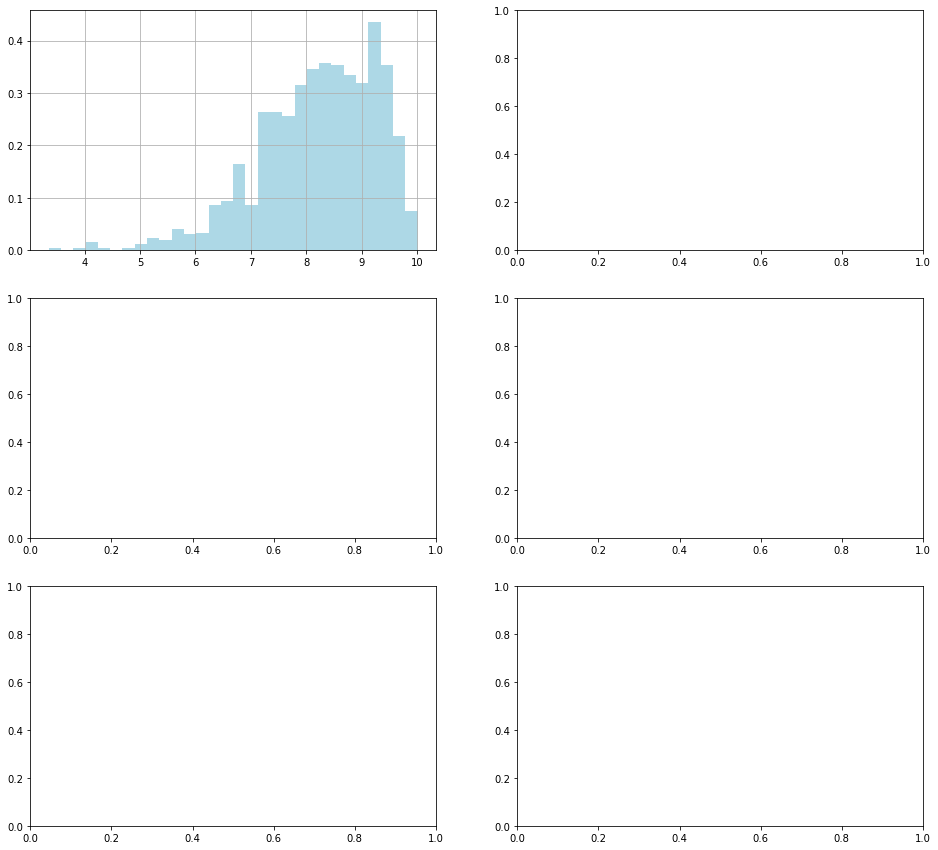

In [10]:
unc.plot_distribution(log=True);

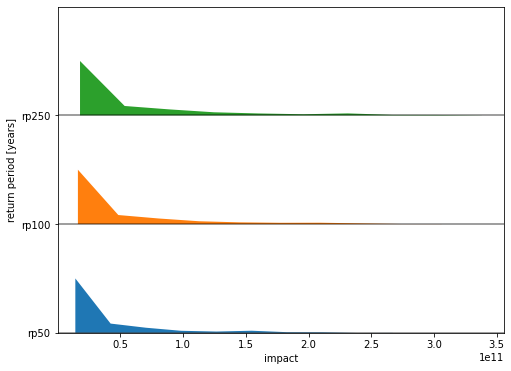

In [17]:
# Specific plot for the return period distributions
unc.plot_rp_distribution();

Now that a distribution of the impact metrics has been computed for each sample, we can also compute the sensitivity indices for each metrics to each uncertainty parameter. Note that the chosen method for the sensitivity analysis should correpond to its sampling partner as defined in the [SAlib](https://salib.readthedocs.io/en/latest/api.html) package.

The sensitivity indices dictionnaries outputs from the SAlib methods are stored in the same structure of nested dictionnaries as the metrics distributions. Note that depending on the chosen sensitivity analysis method the returned indices dictionnary will return specific types of sensitivity indices with specific names. Please get familiar with [SAlib](https://salib.readthedocs.io/en/latest/api.html) for more information.

Note that in our case, several of the second order sensitivity indices are negative. For the default method `sobol`, this indicates that the algorithm has not converged and cannot give realiable values for these sensitivity indices. If this happens, please use a larger number of samples. Here we will focus on the first-order indices.

In [18]:
unc.calc_sensitivity()

{'aai_agg': {'aai_agg': {'S1': array([0.35319533, 0.02894084, 0.29014581, 0.00245273, 0.07358847]),
   'S1_conf': array([0.16768626, 0.0395821 , 0.23823382, 0.0226303 , 0.13207869]),
   'ST': array([0.45797138, 0.02597843, 0.58556506, 0.01358738, 0.2763128 ]),
   'ST_conf': array([0.25127294, 0.0157814 , 0.32831436, 0.0083339 , 0.13765939]),
   'S2': array([[        nan, -0.24100036, -0.0349894 , -0.24132635, -0.169576  ],
          [        nan,         nan, -0.05162803, -0.04726681, -0.04375917],
          [        nan,         nan,         nan, -0.02073784,  0.00665134],
          [        nan,         nan,         nan,         nan, -0.00056325],
          [        nan,         nan,         nan,         nan,         nan]]),
   'S2_conf': array([[       nan, 0.27974028, 0.46249507, 0.27185608, 0.29538608],
          [       nan,        nan, 0.07961535, 0.07261091, 0.05229   ],
          [       nan,        nan,        nan, 0.30176581, 0.34000492],
          [       nan,        nan,  

The value of the sensitivity indices can be plotted for each metric that is one-dimensional (`eai_exp` and `at_event` are not shown in this plot). 

As expected, the `tot_value` of the exposure is only dependent on the exposure parameter `x_exp`. We further see that both the errors in `freq_curve` and in `aai_agg` are mostly determined by `x_exp` and `v_half`. Finally, we see small differences in the sensitivity of the different return periods.

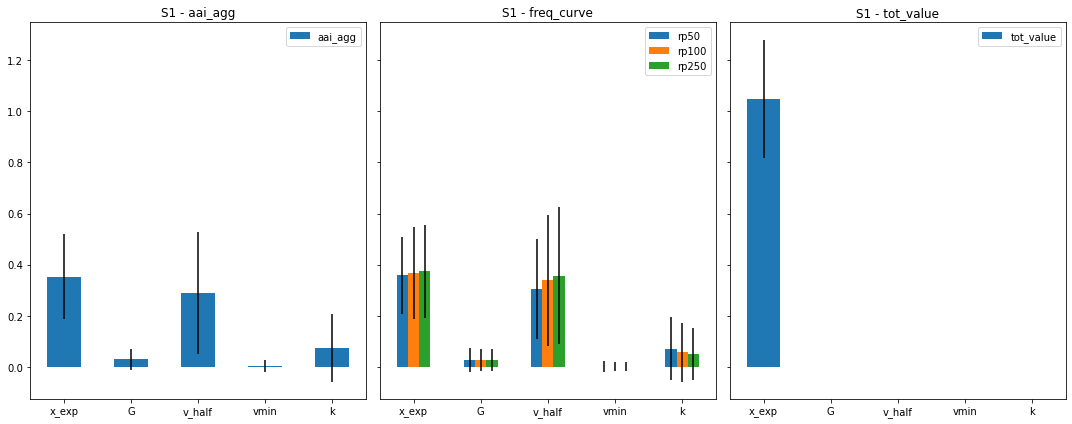

In [19]:
# Default for 'sobol' is to plot 'S1' sensitivity index.
unc.plot_sensitivity();

Note that since we have quite a few measures, the imp_meas_fut and imp_meas_pres plots are too crowded. We can select only the other metrics easily. In addition, instead of showing first order sensitivity 'S1', we can plot the total sensitivity 'ST'.

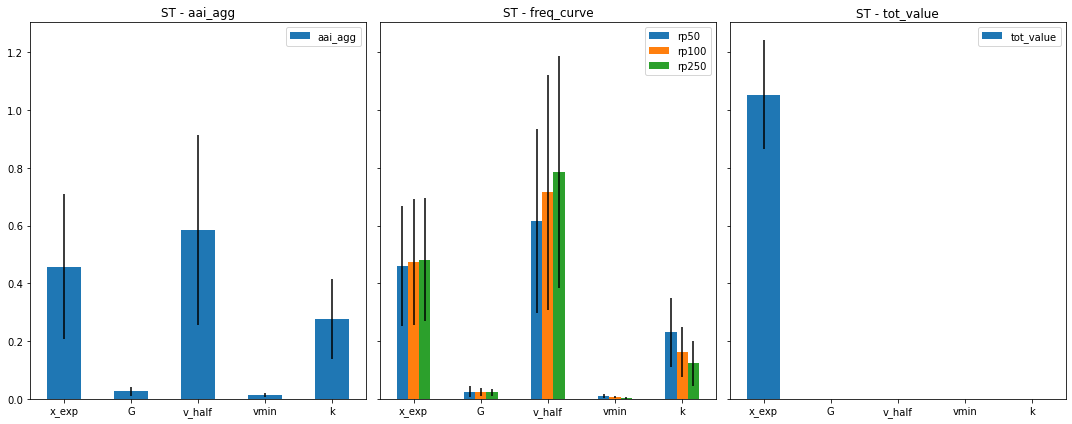

In [20]:
unc.plot_sensitivity(salib_si = 'ST');

### A few non-default parameters

We shall use the same uncertainty variables as in the previous section but show a few possibilities to use non-default method arguments.

In [21]:
# Sampling method "latin" hypercube instead of `saltelli`.
from climada.engine.uncertainty import UncImpact

unc = UncImpact(exp_unc, impf_unc, haz)
unc.make_sample(N=1000, sampling_method='latin')

2021-03-26 11:36:18,055 - climada.engine.uncertainty.base - INFO - Effective number of made samples: 1000


,x_exp,G,v_half,vmin,k
0,0.887267,0.966288,119.881746,8.547775,3.215209
1,0.479814,0.969041,112.241233,8.973467,3.208629
2,0.078982,0.913192,87.889683,8.687317,1.501165
3,0.481808,1.195746,117.841330,5.193562,1.883103
4,0.838435,0.909406,98.007572,5.863301,1.030999
...,...,...,...,...,...
995,0.625321,0.841656,93.838074,13.382201,5.279137
996,0.151135,0.929379,102.012058,12.238470,4.806664
997,0.175844,1.169070,71.536094,3.163649,3.500282
998,0.297115,1.019476,76.088339,8.603385,4.981006


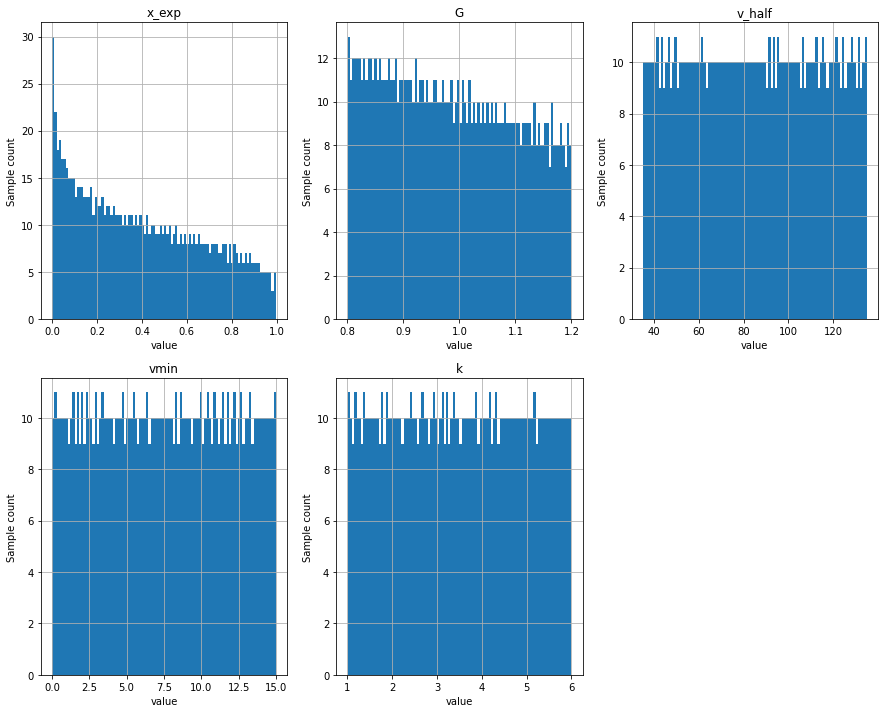

In [22]:
unc.plot_sample();

In [23]:
# Compute also the distribution of the metric `eai_exp`
# To speed-up the comutations, we use a ProcessPool for parallel computations
from pathos.pools import ProcessPool as Pool
pool = Pool()
unc.calc_distribution(rp = [50, 100, 250], calc_eai_exp=True, pool=pool)
pool.close() #Do not forget to close your pool!
pool.join()
pool.clear()

2021-03-26 11:36:22,661 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:22,664 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:22,667 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:22,675 - climada.engine.uncertainty.unc_impact - INFO - 

Estimated computation time: 3.2125s

2021-03-26 11:36:22,815 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:22,819 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:22,822 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26

2021-03-26 11:36:22,982 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:22,986 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:22,987 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:22,991 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:22,992 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:22,995 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:22,995 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:22,996 -

2021-03-26 11:36:23,104 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:23,104 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:23,104 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:23,106 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:23,108 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:23,110 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:23,105 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:2

2021-03-26 11:36:23,182 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:23,194 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:23,195 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:23,197 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:23,198 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:23,198 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:23,201 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:2

2021-03-26 11:36:23,277 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:23,280 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:23,279 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:23,282 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:23,282 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:23,285 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:23,285 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:2

2021-03-26 11:36:23,360 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:23,361 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:23,361 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:23,362 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:23,363 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:23,365 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:23,365 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:2

2021-03-26 11:36:23,413 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:23,414 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:23,411 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:23,415 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:23,417 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:23,417 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:23,418 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021

2021-03-26 11:36:23,463 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:23,464 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:23,465 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:23,465 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:23,468 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:23,472 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:23,473 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:23,475 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shi

2021-03-26 11:36:23,559 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:23,561 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:23,563 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:23,565 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:23,566 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:23,568 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:23,566 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021

2021-03-26 11:36:23,659 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:23,660 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:23,664 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:23,664 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:23,666 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:23,669 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:23,674 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:23,663 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting t

2021-03-26 11:36:23,748 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:23,751 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:23,751 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:23,751 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:23,745 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:23,754 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:23,755 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:2

2021-03-26 11:36:23,840 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:23,846 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:23,847 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:23,847 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:23,850 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:23,852 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:23,853 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:23,856 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:23,

2021-03-26 11:36:23,912 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:23,918 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:23,915 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:23,916 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:23,917 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:23,919 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-2

2021-03-26 11:36:23,996 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:23,999 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:24,001 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:24,000 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:24,003 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:24,003 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:24,005 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:2

2021-03-26 11:36:24,086 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:24,087 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:24,095 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:24,094 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:24,095 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:24,098 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:24,102 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021

2021-03-26 11:36:24,223 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:24,224 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:24,224 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:24,224 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:24,225 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:24,230 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:24,231 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021

2021-03-26 11:36:24,278 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:24,278 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:24,280 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:24,278 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:24,283 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:24,283 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:24,281 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:24,283 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:24,

2021-03-26 11:36:24,328 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:24,333 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:24,327 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:24,335 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:24,333 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


2021-03-26 11:36:24,390 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:24,391 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:24,392 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:24,391 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:24,394 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:24,395 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:24,396 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:2

2021-03-26 11:36:24,457 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:24,457 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:24,459 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:24,460 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:24,462 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:24,463 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-2

2021-03-26 11:36:24,533 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:24,539 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:24,541 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:24,541 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:24,543 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:24,543 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-2

2021-03-26 11:36:24,614 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:24,614 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:24,614 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:24,617 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:24,617 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:24,617 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:24,618 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:2

2021-03-26 11:36:24,685 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:24,685 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:24,680 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:24,685 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:24,688 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:24,689 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:24,690 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:24,693 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:24,678 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin

2021-03-26 11:36:24,748 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:24,747 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:24,746 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:24,748 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:24,749 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:24,750 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:24,753 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:24,755 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:24,756 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:24,75

2021-03-26 11:36:24,819 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:24,820 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:24,822 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:24,824 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:24,823 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:24,825 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-2

2021-03-26 11:36:24,887 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:24,887 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:24,889 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:24,890 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:24,890 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:24,891 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:24,893 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:24,893 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:24,893 - c

2021-03-26 11:36:24,954 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:24,954 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:24,954 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:24,954 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:24,955 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:24,956 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36

2021-03-26 11:36:25,050 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:25,051 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:25,054 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:25,055 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:25,060 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:25,059 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:25,060 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider s

2021-03-26 11:36:25,129 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:25,140 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:25,135 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:25,139 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:25,143 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:25,126 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:25,148 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:25,152 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the orig

2021-03-26 11:36:25,233 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:25,234 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:25,235 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:25,236 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:25,237 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:25,239 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:25,241 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:25,241 -

2021-03-26 11:36:25,312 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:25,312 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:25,313 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:25,312 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:25,316 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC


2021-03-26 11:36:25,390 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:25,389 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:25,391 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:25,391 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:25,392 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:25,395 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:25,396 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:25,396 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:25,407 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shift

2021-03-26 11:36:25,484 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:25,487 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:25,487 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:25,488 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:25,488 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:25,492 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-2

2021-03-26 11:36:25,568 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:25,571 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:25,571 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:25,571 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:25,572 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:25,575 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:25,576 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the or

2021-03-26 11:36:25,627 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:25,629 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:25,629 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:25,629 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:25,629 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:25,632 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:25,634 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:25,636 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11

2021-03-26 11:36:25,680 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:25,683 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:25,683 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:25,684 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:25,687 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:25,688 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:25,690 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 

2021-03-26 11:36:25,739 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:25,740 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:25,741 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:25,743 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:25,744 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:25,744 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:25,747 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:25,748 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:25,

2021-03-26 11:36:25,811 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:25,814 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:25,814 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:25,811 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:25,810 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:25,818 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:25,820 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:25,819 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11

2021-03-26 11:36:25,889 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:25,890 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:25,889 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:25,892 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:25,894 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:25,895 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:25,891 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:25,896 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:25,896 - climada.

2021-03-26 11:36:25,979 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:25,979 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:25,980 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:25,984 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:25,985 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:25,988 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-2

2021-03-26 11:36:26,064 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:26,064 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:26,064 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:26,068 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:26,072 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:26,071 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:26,071 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:2

2021-03-26 11:36:26,169 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:26,172 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:26,175 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:26,175 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:26,175 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:26,176 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:26,178 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:26,179 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:26,179 - climada.engine.

2021-03-26 11:36:26,275 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:26,278 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:26,280 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:26,283 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:26,283 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:26,287 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:26,287 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider s

2021-03-26 11:36:26,364 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:26,366 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:26,365 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:26,366 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:26,364 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensit

2021-03-26 11:36:26,435 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:26,436 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:26,425 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:26,430 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:26,440 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:26,440 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:26,441 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting

2021-03-26 11:36:26,507 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:26,510 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:26,509 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:26,511 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:26,514 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:26,513 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:26,517 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:26,510 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the orig

2021-03-26 11:36:26,592 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:26,592 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:26,593 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:26,595 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:26,596 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:26,599 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:26,600 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:2

2021-03-26 11:36:26,655 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:26,667 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:26,669 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:26,669 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:26,667 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:26,669 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:26,674 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:26,675 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:26,

2021-03-26 11:36:26,743 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:26,739 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:26,746 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:26,750 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:26,751 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:26,750 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-2

2021-03-26 11:36:26,821 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:26,823 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:26,824 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:26,821 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:26,825 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:26,825 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-2

2021-03-26 11:36:26,886 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:26,889 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:26,890 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:26,890 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:26,891 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:26,891 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:26,894 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:26,895 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11

2021-03-26 11:36:26,949 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:26,949 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:26,949 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:26,950 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:26,950 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:26,951 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:26,954 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:26,954 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:26,

2021-03-26 11:36:27,035 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:27,037 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:27,041 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:27,041 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:27,041 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:27,045 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-2

2021-03-26 11:36:27,144 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:27,147 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:27,152 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:27,154 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:27,158 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 11:36:27,158 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 11:36:27,161 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 11:36:2

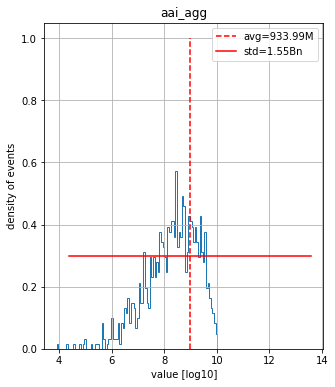

In [24]:
# plot the aai_agg distribution only
unc.plot_distribution(metric_list=['aai_agg']);

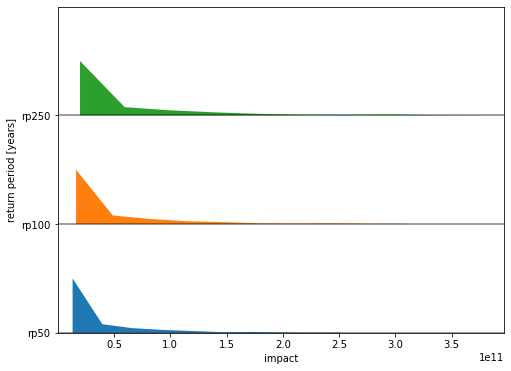

In [25]:
unc.plot_rp_distribution();

In [26]:
# Use the method 'rbd_fast' which is recommend in pair with 'latin'. In addition, change one of the kwargs 
# (M=15) of the salib sampling method.
unc.calc_sensitivity(salib_method='rbd_fast', method_kwargs = {'M': 15})

{'aai_agg': {'aai_agg': {'S1': [0.2094417963929679,
    0.03713357646191098,
    0.3374376803490705,
    0.009144986915045963,
    0.13299512699521301],
   'names': ['x_exp', 'G', 'v_half', 'vmin', 'k']}},
 'freq_curve': {'rp50': {'S1': [0.21065929325872196,
    0.03770708839721268,
    0.3567505327880907,
    0.007662457832108196,
    0.11279386724420079],
   'names': ['x_exp', 'G', 'v_half', 'vmin', 'k']},
  'rp100': {'S1': [0.22280731328977452,
    0.04085507224584279,
    0.3911374120945809,
    0.006159794573239015,
    0.07502669106427702],
   'names': ['x_exp', 'G', 'v_half', 'vmin', 'k']},
  'rp250': {'S1': [0.23142782895821237,
    0.04288524486110207,
    0.40906561197506647,
    0.005183036730958358,
    0.05064482394447519],
   'names': ['x_exp', 'G', 'v_half', 'vmin', 'k']}},
 'eai_exp': {0: {'S1': [0.2194816778491107,
    0.03871951221379582,
    0.35212420418052914,
    0.008258030988556968,
    0.11565091687016411],
   'names': ['x_exp', 'G', 'v_half', 'vmin', 'k']},
  

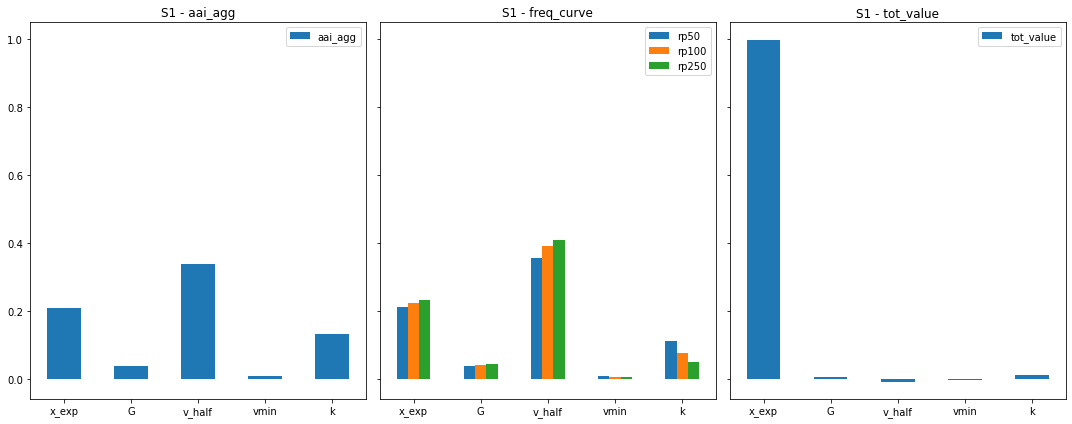

In [27]:
unc.plot_sensitivity();

Since we computed the distribution and sensitivity indices for the total impact at each exposure point, we can plot a map of the largest sensitivity index in each exposure location. This yields a rather suprising result that for every location, the most sensitive parameter is `x_exp`, the exposures scaling parameter.

/Users/ckropf/Documents/Climada/climada_python/climada/util/plot.py:480: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


array([<cartopy.mpl.geoaxes.GeoAxesSubplot object at 0x7fb474193c90>],
      dtype=object)

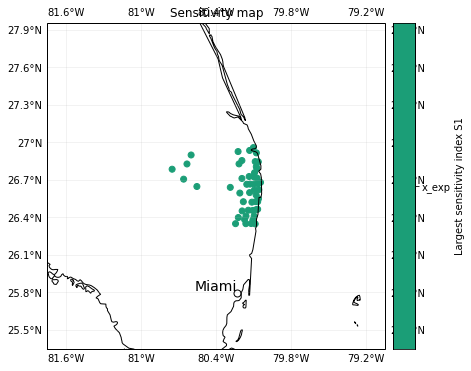

In [28]:
unc.plot_sensitivity_map(exp_base)

## UncCostBenefit

The uncertainty and sensitivity analysis for CostBenefit is completely analogous to the Impact case. It is slightly more complex as there are more input variables.

Define the uncvar_func.

In [1]:
import copy
from climada.util.constants import ENT_DEMO_TODAY, ENT_DEMO_FUTURE, HAZ_DEMO_H5
from climada.entity import Entity
from climada.hazard import Hazard

# Entity today has an uncertainty in the total asset value
def ent_today_func(x_ent):
    entity = Entity()
    entity.read_excel(ENT_DEMO_TODAY)
    entity.exposures.ref_year = 2018
    entity.exposures.gdf.value *= x_ent
    return entity

# Entity in the future has a +- 10% uncertainty in the cost of all the adapatation measures
def ent_fut_func(m_fut_cost):
    entity = Entity()
    entity.read_excel(ENT_DEMO_FUTURE)
    entity.exposures.ref_year = 2040  
    for meas in entity.measures.get_measure('TC'):
        meas.cost *= m_fut_cost
    return entity

haz_base = Hazard()
haz_base.read_hdf5(HAZ_DEMO_H5)

# The hazard intensity in the future is also uncertainty by a multiplicative factor
def haz_fut_func(x_haz_fut, haz=haz_base):
    haz = copy.deepcopy(haz_base)
    haz.intensity = haz.intensity.multiply(x_haz_fut)
    return haz


/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


2021-03-26 12:00:13,602 - climada.hazard.base - INFO - Reading /Users/ckropf/climada/demo/data/tc_fl_1990_2004.h5


Check that costs for measures are changed as desired.

In [2]:
costs_1 = [meas.cost for meas in ent_fut_func(1).measures.get_measure('TC')]
costs_05 = [meas.cost for meas in ent_fut_func(0.5).measures.get_measure('TC')]
print(f"\nThe cost for m_fut_cost=1 are {costs_1}\n"
     f"The cost for m_fut_cost=0.5 are {costs_05}")

2021-03-26 12:00:13,626 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-26 12:00:13,627 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-26 12:00:13,628 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-26 12:00:13,629 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-26 12:00:13,630 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-26 12:00:13,667 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-26 12:00:13,667 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-26 12:00:13,668 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-26 12:00:13,668 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-26 12:00:13,668 - climada.entity.exposures.base - INFO - crs set to default

Define the UncVars

In [3]:
import scipy as sp
from climada.engine.uncertainty import UncVar

haz_today = haz_base

haz_fut_distr = {"x_haz_fut": sp.stats.uniform(1, 3),
              }
haz_fut_unc = UncVar(haz_fut_func, haz_fut_distr)

ent_today_distr = {"x_ent":  sp.stats.uniform(0.7, 1)}
ent_today_unc = UncVar(ent_today_func, ent_today_distr)

ent_fut_distr = {"m_fut_cost":  sp.stats.norm(1, 0.1)}
ent_fut_unc = UncVar(ent_fut_func, ent_fut_distr)

Initialize the UncCostBenefit object and make a sample with N=10. Set `calc_second_order=False`.

In [4]:
from climada.engine.uncertainty import UncCostBenefit

unc = UncCostBenefit(haz_unc=haz_today, ent_unc=ent_today_unc,
                     haz_fut_unc=haz_fut_unc, ent_fut_unc=ent_fut_unc)
unc.make_sample(N=10, sampling_kwargs={'calc_second_order':False})

2021-03-26 12:00:13,936 - climada.engine.uncertainty.base - INFO - Effective number of made samples: 50


,x_ent,x_haz_fut,m_fut_cost
0,0.919727,1.290039,1.004653
1,1.376758,1.290039,1.004653
2,0.919727,1.840820,1.004653
3,0.919727,1.290039,1.132387
4,1.376758,1.840820,1.132387
5,1.419727,2.790039,0.791544
6,0.876758,2.790039,0.791544
7,1.419727,3.340820,0.791544
8,1.419727,2.790039,0.976531
9,0.876758,3.340820,0.976531


For longer computations, it is possible to use a pool for parallel computation.

In [5]:
from pathos.pools import ProcessPool as Pool

pool = Pool()
unc.calc_distribution(pool=pool)
pool.close() #Do not forget to close your pool!
pool.join()
pool.clear()

2021-03-26 12:00:14,848 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-26 12:00:14,850 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-26 12:00:14,851 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-26 12:00:14,851 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-26 12:00:14,853 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-26 12:00:14,893 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-26 12:00:14,894 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-26 12:00:14,894 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-26 12:00:14,895 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-26 12:00:14,895 - climada.entity.exposures.base - INFO - crs set to default

2021-03-26 12:00:15,291 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-26 12:00:15,294 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-26 12:00:15,294 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-26 12:00:15,297 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-26 12:00:15,300 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-26 12:00:15,301 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-26 12:00:15,305 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-26 12:00:15,309 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-26 12:00:15,326 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-26 12:00:15,329 - climada.entity.exposures.base - INFO - meta set to default value {}
2

2021-03-26 12:00:15,556 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-26 12:00:15,556 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-26 12:00:15,559 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-26 12:00:15,559 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-26 12:00:15,562 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-26 12:00:15,565 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-26 12:00:15,568 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-26 12:00:15,581 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-26 12:00:15,585 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-26 12:00:15,585 - climada.entity.exposures.base - INFO - meta set to defau

2021-03-26 12:00:15,818 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:15,816 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:15,819 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:15,819 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:15,822 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:15,823 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:15,821 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:15,825 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:15,825 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:15,828 - cli

2021-03-26 12:00:15,904 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:15,905 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-03-26 12:00:15,905 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:15,907 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:15,907 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:15,909 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:15,910 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.

2021-03-26 12:00:15,906 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:15,910 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:15,914 - clima

2021-03-26 12:00:15,983 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:15,984 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:15,983 - climada.engine.cost_benefit - INFO - Computing cost benefit from years 2018 to 2040.
2021-03-26 12:00:15,986 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:15,989 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC

2021-03-26 12:00:15,991 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:15,987 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:15,992 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:15,979 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.

2021-03-26 12:00:15,994 - c

2021-03-26 12:00:16,058 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-26 12:00:16,060 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-26 12:00:16,064 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-26 12:00:16,064 - climada.engine.cost_benefit - INFO - Computing cost benefit from years 2018 to 2040.

--------------------  --------  --------
Total climate risk:   77.3685   (USD bn)
Average annual risk:   8.85395  (USD bn)
Residual risk:        31.5735   (USD bn)
--------------------  --------  --------
Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.40806           12.9695         9.21086
Beach nourishment          1.85485           10.0334         5.40926
Seawall                    9.53057            0.255559       0.0268147
Building code              9.

2021-03-26 12:00:16,313 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-26 12:00:16,315 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-26 12:00:16,318 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-26 12:00:16,321 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-26 12:00:16,328 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-26 12:00:16,333 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-26 12:00:16,336 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-26 12:00:16,338 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-26 12:00:16,339 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-26 12:00:16,340 - climada.entity.exposures.base - INFO - meta set to default value {}
2

2021-03-26 12:00:16,599 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-03-26 12:00:16,599 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:16,603 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:16,604 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:16,603 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:16,610 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:16,609 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:16,611 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:16,614 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:16,614 -

2021-03-26 12:00:16,695 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:16,697 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:16,700 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:16,701 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-03-26 12:00:16,702 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:16,703 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:16,704 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:16,703 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-03-26 12:00:16,703 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:16,708 - climada.e

Building code              9.2428           1.78488        0.1931112021-03-26 12:00:16,788 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:16,790 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC

2021-03-26 12:00:16,793 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:16,793 - climada.engine.cost_benefit - INFO - Computing cost benefit from years 2018 to 2040.

2021-03-26 12:00:16,792 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:16,791 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:16,795 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
--------------------  --------  --------
Total climate risk:   7.13953   (USD bn)
Average annual risk:  0.707117  (USD bn)
Residual risk:        0.037919  (USD bn)
------------------

Building code              8.27455          19.3421         2.33754

Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.23081             7.6526         6.21754
Beach nourishment          1.62135             5.92005        3.65131
Seawall                    8.33079             1.85488        0.222653
Building code              8.63219            45.0948         5.22403


--------------------  --------  --------
Total climate risk:   77.3685   (USD bn)
Average annual risk:   8.85395  (USD bn)
Residual risk:        31.5735   (USD bn)
--------------------  --------  --------
--------------------  --------  --------
Total climate risk:   180.379   (USD bn)
Average annual risk:   20.8872  (USD bn)
Residual risk:        119.857   (USD bn)
--------------------  --------  --------2021-03-26 12:00:16,873 - climada.entity.exposures.base - INFO - meta set to default value {}

20

2021-03-26 12:00:17,032 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-26 12:00:17,034 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-26 12:00:17,034 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-26 12:00:17,037 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-26 12:00:17,038 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-26 12:00:17,040 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-26 12:00:17,042 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-26 12:00:17,046 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-26 12:00:17,106 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-26 12:00:17,119 - climada.entity.exposures.base - INFO - tag set to default value  File

2021-03-26 12:00:17,291 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-26 12:00:17,294 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-26 12:00:17,294 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-26 12:00:17,296 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-26 12:00:17,297 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-26 12:00:17,299 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-26 12:00:17,300 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-26 12:00:17,390 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-03-26 12:00:17,400 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:17,402 - climada.entity.exposures.base - INFO -

2021-03-26 12:00:17,502 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:17,504 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:17,504 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:17,503 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:17,505 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:17,502 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-03-26 12:00:17,507 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:17,507 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:17,510 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:17,511 - climad

--------------------  --------  --------
Total climate risk:   180.379   (USD bn)
Average annual risk:   20.8872  (USD bn)
Residual risk:        119.857   (USD bn)
--------------------  --------  --------2021-03-26 12:00:17,569 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:17,570 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-26 12:00:17,572 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.

2021-03-26 12:00:17,574 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:17,574 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:17,575 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
Net Present Values
2021-03-26 12:00:17,578 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC

2021-03-26 12:00:17,579 - clima

2021-03-26 12:00:17,646 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:17,647 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:17,647 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:17,650 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:17,651 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:17,638 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-26 12:00:17,650 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-26 12:00:17,652 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:17,653 - climada.engine.cost_benefit - INFO - Computing cost benefit from years 2018 to 2040.
2021-03-26 12:00:1

2021-03-26 12:00:17,744 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-26 12:00:17,745 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-26 12:00:17,747 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-26 12:00:17,751 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-26 12:00:17,753 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-26 12:00:17,756 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-26 12:00:17,757 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-26 12:00:17,764 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-26 12:00:17,770 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-26 12:00:17,774 - climada.entity.exposures.base - INFO - value_unit set to 

2021-03-26 12:00:17,989 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-26 12:00:17,996 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-26 12:00:17,996 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-26 12:00:18,000 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-26 12:00:18,000 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-26 12:00:18,003 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-26 12:00:18,005 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-26 12:00:18,005 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-26 12:00:18,011 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-26 12:00:18,012 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 De

2021-03-26 12:00:18,229 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:18,231 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:18,232 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-03-26 12:00:18,234 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:18,234 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:18,236 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:18,237 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:18,240 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:18,239 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:18,241 - climad

Building code              9.57251         0.768379        0.08026932021-03-26 12:00:18,315 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:18,317 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC

2021-03-26 12:00:18,319 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:18,318 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:18,319 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:18,323 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.

2021-03-26 12:00:18,325 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:18,324 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:18,324 - climada.engine.impact - INFO - Calcul

2021-03-26 12:00:18,405 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-26 12:00:18,410 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:18,409 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC

2021-03-26 12:00:18,413 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-26 12:00:18,414 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:18,415 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:18,414 - climada.entity.exposures.base - INFO - meta set to default value {}
Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.36004            8.74424        6.42941
Beach nourishment          1.79159            6.76879        3.

2021-03-26 12:00:18,529 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-26 12:00:18,534 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-26 12:00:18,536 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-26 12:00:18,536 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-26 12:00:18,539 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-26 12:00:18,540 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-26 12:00:18,542 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-26 12:00:18,543 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-26 12:00:18,545 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-26 12:00:18,546 - climada.entity.exposures.base - INFO - value_unit set to 

2021-03-26 12:00:18,802 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-26 12:00:18,802 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-26 12:00:18,806 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-26 12:00:18,805 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-26 12:00:18,812 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-26 12:00:18,813 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-26 12:00:18,814 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-26 12:00:18,816 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-26 12:00:18,817 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-26 12:00:18,817 - climada.entity.exposures.base - INFO - tag set to default value 

2021-03-26 12:00:19,053 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:19,054 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:19,055 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-03-26 12:00:19,057 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:19,058 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:19,061 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-03-26 12:00:19,062 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:19,066 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-03-26 12:00:19,065 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:19,069 


2021-03-26 12:00:19,150 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:19,151 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
--------------------  --------  --------
Total climate risk:   186.481   (USD bn)
Average annual risk:   21.5861  (USD bn)
Residual risk:        124.112   (USD bn)
--------------------  --------  --------
2021-03-26 12:00:19,155 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:19,156 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:19,158 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-03-26 12:00:19,159 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
Net Present Values2021-03-26 12:00:19,160 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.

2021-03-26 12:00:1


2021-03-26 12:00:19,245 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:19,245 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:19,248 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.32238            8.25573         6.24311
Beach nourishment          1.74197            6.27247         3.60078
Seawall                    8.95058            0.913258        0.102033
Building code              9.2744            41.4426          4.46849
2021-03-26 12:00:19,251 - climada.entity.exposures.base - INFO - meta set to default value {}

2021-03-26 12:00:19,254 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
Measure              Cost (USD bn) 

Building code              8.58229           38.0512         4.43368Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.32819            8.96663        6.75103
Beach nourishment          1.74963            7.03873        4.02299
Seawall                    8.98991            0.751479       0.0835913
Building code              9.31515           40.5839         4.356762021-03-26 12:00:19,330 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326






2021-03-26 12:00:19,335 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
--------------------  --------  --------
Total climate risk:   152.205   (USD bn)
Average annual risk:   17.6093  (USD bn)
Residual risk:         96.4205  (USD bn)
--------------------  --------  ----------------------------  --------  --------
Total climate risk:   162.336   (USD bn)
Average annual risk

2021-03-26 12:00:19,575 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-26 12:00:19,576 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-26 12:00:19,577 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-26 12:00:19,581 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-26 12:00:19,581 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-26 12:00:19,585 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-26 12:00:19,587 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-26 12:00:19,589 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-26 12:00:19,592 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-26 12:00:19,593 - climada.entity.exposures.base - INFO - value_unit set to 

2021-03-26 12:00:19,844 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:19,845 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:19,846 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-03-26 12:00:19,850 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:19,850 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:19,857 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:19,855 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:19,858 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:19,860 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:19,866 - climad

2021-03-26 12:00:19,953 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:19,959 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.06922          10.7463        10.0506
Beach nourishment          1.40849           8.75119        6.21319
Seawall                    7.23706           0.0192535      0.00266041
Building code              7.49889           7.73749        1.031822021-03-26 12:00:19,963 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC

2021-03-26 12:00:19,963 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:19,956 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:19,967 - climada.engine.impact - INFO - 

2021-03-26 12:00:20,073 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-03-26 12:00:20,076 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC

2021-03-26 12:00:20,077 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:20,079 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:20,079 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-26 12:00:20,082 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:20,083 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:20,084 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
--------------------  -------  --------
Total climate risk:   97.1092  (USD bn)
Average annual risk:  11.23    (USD bn)
Residual risk:        46.2242  (

Building code              9.31515           2.43894       0.261825

--------------------  --------  --------
Total climate risk:   9.75575   (USD bn)
Average annual risk:  1.02177   (USD bn)
Residual risk:        0.497501  (USD bn)
--------------------  --------  --------
Net Present Values
2021-03-26 12:00:20,316 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-26 12:00:20,319 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-26 12:00:20,321 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-26 12:00:20,324 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-26 12:00:20,327 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-26 12:00:20,358 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-26 12:00:20,361 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Descr

2021-03-26 12:00:21,137 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:21,140 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:21,145 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:21,147 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:21,152 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:21,155 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:21,161 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:21,163 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 12:00:21,168 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 12:00:21,171 - climada.en

The output of `CostBenefit.calc` is rather complex in its structure. The metrics dictionary inherits this complexity.

In [7]:
#Top level metrics keys
macro_metrics = list(unc.metrics.keys())
macro_metrics

['tot_climate_risk',
 'benefit',
 'cost_ben_ratio',
 'imp_meas_present',
 'imp_meas_future']

In [8]:
# The benefits and the cost_ben_ratio are available for each measuret
print(list(unc.metrics['benefit'].keys()))
print(list(unc.metrics['cost_ben_ratio'].keys()))

['Mangroves', 'Beach nourishment', 'Seawall', 'Building code']
['Mangroves', 'Beach nourishment', 'Seawall', 'Building code']


In [9]:
# The impact_meas_present and impact_meas_future provide values of the cost_meas, risk_transf, risk, 
# and cost_ins for each measure
print(list(unc.metrics['imp_meas_present'].keys()))
print(list(unc.metrics['imp_meas_future'].keys()))

['no measure-risk', 'no measure-risk_transf', 'no measure-cost_meas', 'no measure-cost_ins', 'Mangroves-risk', 'Mangroves-risk_transf', 'Mangroves-cost_meas', 'Mangroves-cost_ins', 'Beach nourishment-risk', 'Beach nourishment-risk_transf', 'Beach nourishment-cost_meas', 'Beach nourishment-cost_ins', 'Seawall-risk', 'Seawall-risk_transf', 'Seawall-cost_meas', 'Seawall-cost_ins', 'Building code-risk', 'Building code-risk_transf', 'Building code-cost_meas', 'Building code-cost_ins']
['no measure-risk', 'no measure-risk_transf', 'no measure-cost_meas', 'no measure-cost_ins', 'Mangroves-risk', 'Mangroves-risk_transf', 'Mangroves-cost_meas', 'Mangroves-cost_ins', 'Beach nourishment-risk', 'Beach nourishment-risk_transf', 'Beach nourishment-cost_meas', 'Beach nourishment-cost_ins', 'Seawall-risk', 'Seawall-risk_transf', 'Seawall-cost_meas', 'Seawall-cost_ins', 'Building code-risk', 'Building code-risk_transf', 'Building code-cost_meas', 'Building code-cost_ins']


We can plot the distributions for the top metrics or our choice.

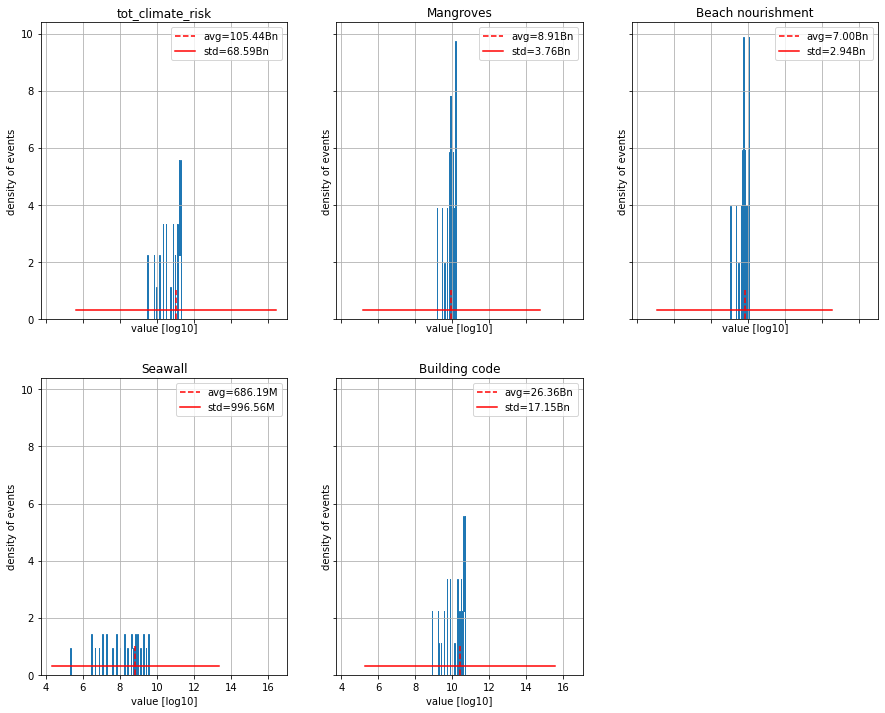

In [10]:
# tot_climate_risk and benefit
unc.plot_distribution(metric_list=['tot_climate_risk', 'benefit']);

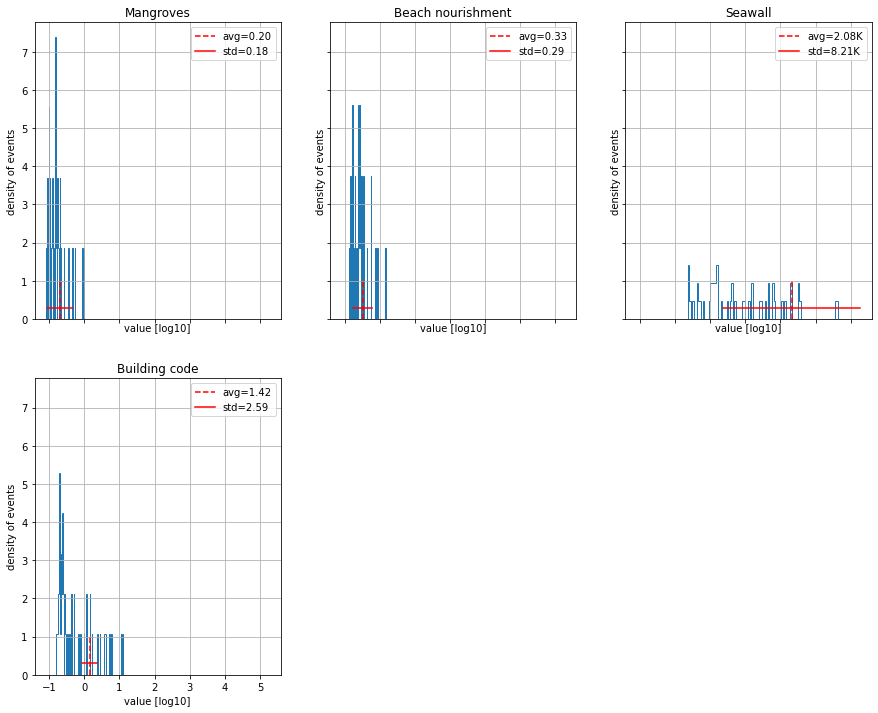

In [11]:
# cost benefit ratio
unc.plot_distribution(metric_list=['cost_ben_ratio'] );

Analogously to the impact example, now that we have a metric distribution, we can compute the sensitivity indices. Since we used the default sampling method, we can use the default sensitivity analysis method. However, since we used `calc_second_order = False` for the sampling, we need to specify the same for the sensitivity analysis.

In [12]:
unc.calc_sensitivity(method_kwargs = {'calc_second_order':False})

/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/SALib/analyze/sobol.py:93: RuntimeWarning: invalid value encountered in true_divide
  Y = (Y - Y.mean()) / Y.std()
/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/SALib/analyze/sobol.py:142: RuntimeWarning: invalid value encountered in double_scalars
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/SALib/analyze/sobol.py:142: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/SALib/analyze/sobol.py:148: RuntimeWarning: invalid value encountered in double_scalars
  return 0.5 * np.mean((A - AB) ** 2, axis=0) / np.var(np.r_[A, B], axis=0)
/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/SALib

{'tot_climate_risk': {'tot_climate_risk': {'S1': array([-0.00203406,  1.30805651,  0.        ]),
   'S1_conf': array([0.00223971, 0.75571535, 0.        ]),
   'ST': array([8.55006831e-06, 1.28467639e+00, 0.00000000e+00]),
   'ST_conf': array([5.64753136e-06, 5.21148960e-01, 0.00000000e+00])}},
 'benefit': {'Mangroves': {'S1': array([0.01508364, 1.4234898 , 0.        ]),
   'S1_conf': array([0.02177875, 0.64787598, 0.        ]),
   'ST': array([6.71986555e-04, 1.16378579e+00, 0.00000000e+00]),
   'ST_conf': array([0.00069589, 0.53506888, 0.        ])},
  'Beach nourishment': {'S1': array([0.01557013, 1.40197455, 0.        ]),
   'S1_conf': array([0.02438308, 0.73728365, 0.        ]),
   'ST': array([7.37074244e-04, 1.15982867e+00, 0.00000000e+00]),
   'ST_conf': array([0.0008065 , 0.59827744, 0.        ])},
  'Seawall': {'S1': array([0.        , 0.84541059, 0.        ]),
   'S1_conf': array([0.        , 1.06154272, 0.        ]),
   'ST': array([0.       , 1.1560475, 0.       ]),
   'ST_

The sensitivity indices can be plotted. For the default method 'sobol', by default the 'S1' sensitivity index is plotted.

Note that since we have quite a few measures, the plot must be adjusted a bit or dropped. Also see that for many metrics, the sensitivity to certain uncertainty parameters appears to be 0. However, this result is to be treated with care. Indeed, we used for demonstration purposes a rather too low number of samples, which is indicated by large confidence intervals (vertical black lines) for most sensitivity indices. For a more robust result the analysis should be repeated with more samples.

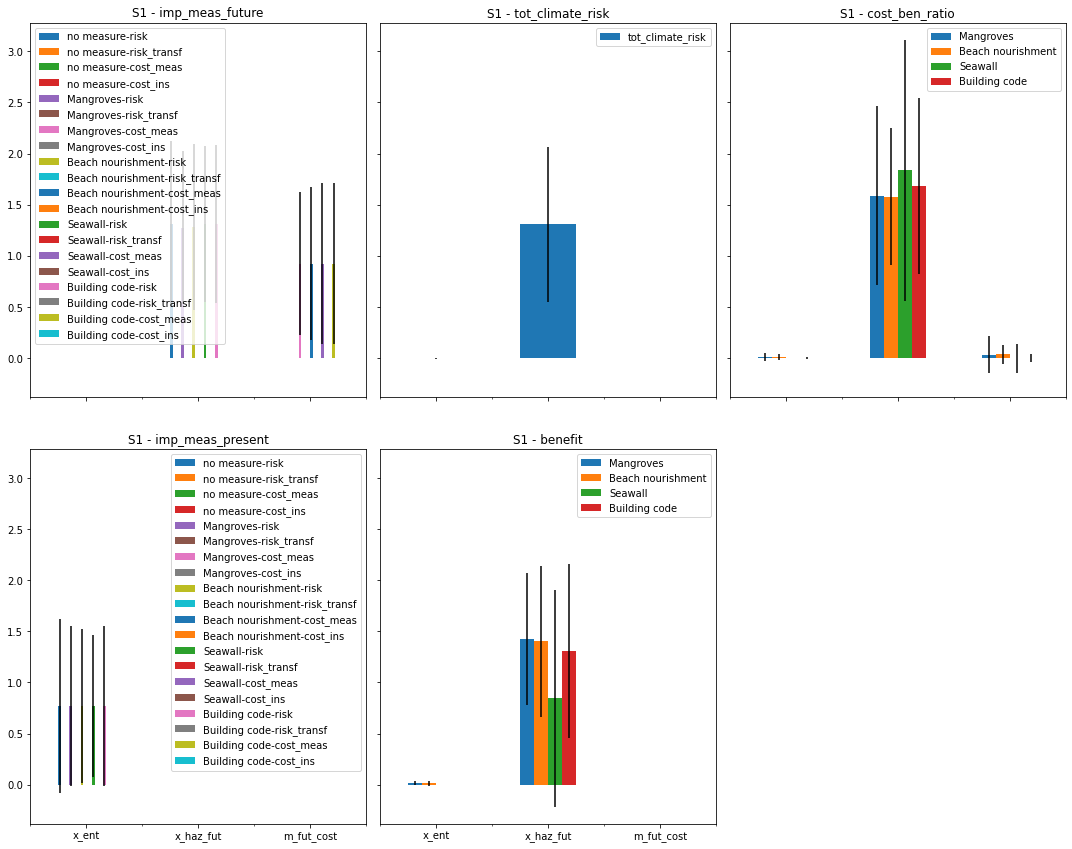

In [15]:
axes = unc.plot_sensitivity();

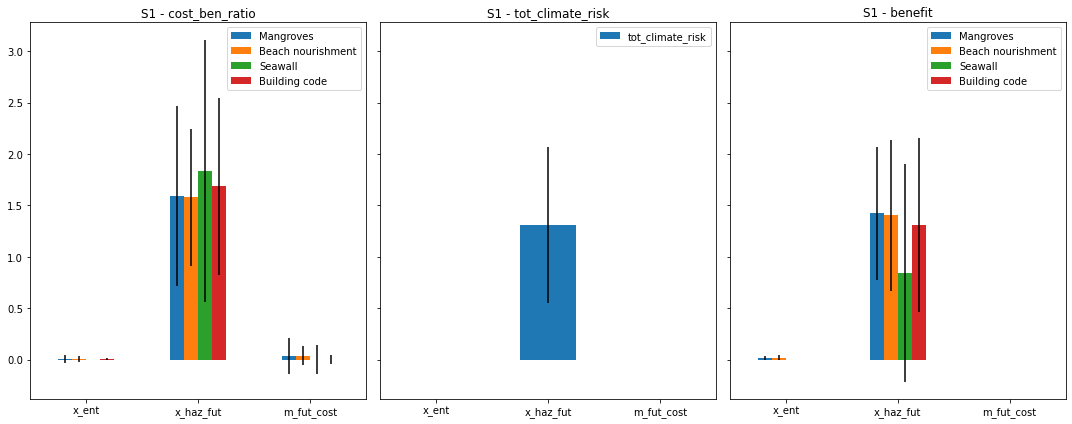

In [16]:
axes = unc.plot_sensitivity(metric_list=['cost_ben_ratio','tot_climate_risk','benefit']);